In [1]:
import os

from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from deepcell_tracking.metrics import calculate_summary_stats

In [2]:
baxter_path = '../benchmarking/Baxter/benchmarks.csv'
embedtrack_path = '../benchmarking/EmbedTrack/benchmarks.csv'
deepcell_path = '../benchmarking/DeepCell/benchmarks.csv'

sum_columns = ['correct_division', 'mismatch_division',
    'false_positive_division', 'false_negative_division', 'total_divisions',
    'aa_tp', 'aa_total', 'te_tp', 'te_total']
mean_columns = ['DET', 'SEG', 'TRA']

In [3]:
# EmbedTrack data
et_df = pd.read_csv(embedtrack_path, index_col=0)
et_df['model'] = 'EmbedTrack ' + et_df['model']

# Rollup data for each model version
et_df_a = et_df[['model'] + sum_columns].groupby('model').sum().reset_index()
et_df_b = et_df[['model'] + mean_columns].groupby('model').mean().reset_index()
et_df = et_df_a.merge(et_df_b, on='model')

In [4]:
# Baxter data
b_df = pd.read_csv(baxter_path, index_col=0)

# Rollup data for each model version
b_df_a = b_df[['model'] + sum_columns].groupby('model').sum().reset_index()
b_df_b = b_df[['model'] + mean_columns].groupby('model').mean().reset_index()
b_df = b_df_a.merge(b_df_b, on='model')

In [5]:
dc_df = pd.read_csv(deepcell_path, index_col=0)

# Rollup data for each model version
dc_df_a = dc_df[['model'] + sum_columns].groupby('model').sum().reset_index()
dc_df_b = dc_df[['model'] + mean_columns].groupby('model').mean().reset_index()
dc_df = dc_df_a.merge(dc_df_b, on='model')

# Plots

In [12]:
df = pd.concat([et_df, b_df, dc_df]).reset_index(drop=True)

In [14]:
def calculate_stats(row):
    cols = ['correct_division', 'false_positive_division', 'false_negative_division', 'total_divisions',
            'aa_tp', 'aa_total', 'te_tp', 'te_total']
    d = row[cols].to_dict()
    return pd.Series(calculate_summary_stats(**d))

df = df.join(df.apply(calculate_stats, axis=1))

In [15]:
df

,model,correct_division,mismatch_division,false_positive_division,false_negative_division,total_divisions,aa_tp,aa_total,te_tp,te_total,DET,SEG,TRA,Division Recall,Division Precision,Division F1,Mitotic branching correctness,Fraction missed divisions,Association Accuracy,Target Effectiveness
0,EmbedTrack Fluo-N2DH-GOWT1,0.0,0.0,15.0,108.0,108.0,4850.0,29504.0,5192.0,30321.0,0.238841,0.179327,0.231180,0.00,0.00,0.00,0.00,1.00,0.16,0.17
1,EmbedTrack Fluo-N2DH-SIM+,0.0,7.0,1500.0,171.0,178.0,25167.0,48390.0,26326.0,49775.0,0.826697,0.397969,0.779315,0.00,0.00,0.00,0.00,0.96,0.52,0.53
2,EmbedTrack Fluo-N2DL-HeLa,108.0,10.0,533.0,60.0,178.0,39605.0,48390.0,40739.0,49775.0,0.816220,0.641730,0.815163,0.64,0.17,0.27,0.15,0.34,0.82,0.82
3,Baxter - Deepcell,86.0,7.0,30.0,85.0,178.0,47610.0,48390.0,48911.0,49775.0,0.988279,0.919609,0.987211,0.50,0.74,0.60,0.43,0.48,0.98,0.98
4,Baxter - GT,104.0,6.0,13.0,68.0,178.0,48171.0,48390.0,49493.0,49775.0,0.997080,0.996160,0.996567,0.60,0.89,0.72,0.56,0.38,1.00,0.99
5,Deepcell - Deepcell,151.0,11.0,10.0,16.0,178.0,47007.0,48390.0,48364.0,49775.0,0.990764,0.923929,0.989835,0.90,0.94,0.92,0.85,0.09,0.97,0.97
6,Deepcell - GT,169.0,1.0,3.0,8.0,178.0,47908.0,48390.0,49293.0,49775.0,1.000000,1.000000,0.999636,0.95,0.98,0.97,0.94,0.04,0.99,0.99


In [8]:
stats_columns = ['Division Precision', 'Division Recall', 'Division F1', 'Mitotic branching correctness', 'Association Accuracy',
       'Target Effectiveness', 'DET', 'SEG', 'TRA']
stats = df[['model']+stats_columns].melt(
    id_vars='model',
    value_vars=stats_columns,
    var_name='metric'
    )

div_columns = ['correct_division', 'mismatch_division', 'false_positive_division', 'false_negative_division']
divisions = df[['model']+div_columns].melt(
    id_vars='model',
    value_vars=div_columns,
    var_name='metric'
    )

In [9]:
# Norm for tab20 colormap
norm = Normalize(vmin=0, vmax=19)

# GT segs are even numbers
colors = {
    'Baxter - GT': cm.tab20(norm(0)),
    'Baxter - Deepcell': cm.tab20(norm(1)),
    'Deepcell - GT': cm.tab20(norm(2)),
    'Deepcell - Deepcell': cm.tab20(norm(3)),
    'EmbedTrack Fluo-N2DH-GOWT1': cm.tab20(norm(5)),
    'EmbedTrack Fluo-N2DH-SIM+': cm.tab20(norm(7)),
    'EmbedTrack Fluo-N2DL-HeLa': cm.tab20(norm(9))
}

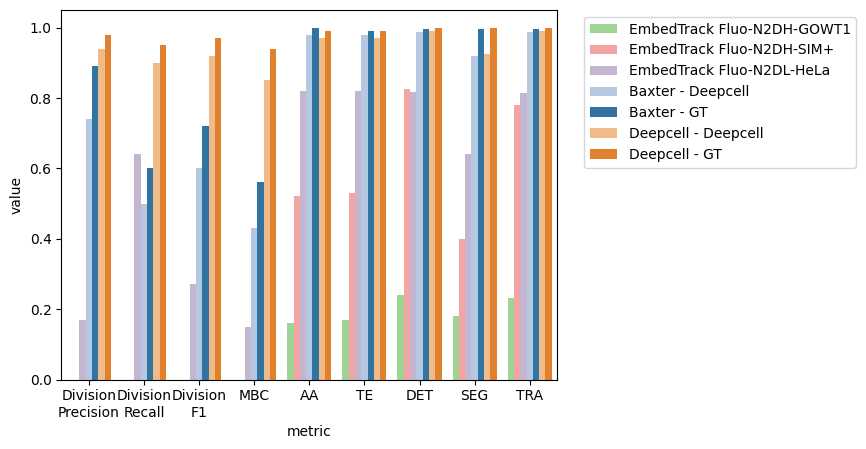

In [10]:
labels = {
    'Division Precision': 'Division\nPrecision',
    'Division Recall': 'Division\nRecall',
    'Division F1': 'Division\nF1',
    'Mitotic branching correctness': 'MBC',
    'Association Accuracy': 'AA',
    'Target Effectiveness': 'TE'
}

sns.barplot(
    data=stats.replace(labels),
    x='metric',
    y='value',
    hue='model',
    palette=colors
) 
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")